# Transformer + RandomForest + AdaBoost
###A comparison for financial time series forecasting

by Muhammad Taha Raees




In [ ]:
!pip install --quiet yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import math
import os

In [ ]:
# User-editable variables
TICKERS = ['XOM','CVX','COP','BP','PBR','EOG']  # multivariate input (oil sector).
TARGET = 'XOM'  # target ticker to forecast
START = '2015-01-01'
END = None  # None means up to today
INTERVAL = '1d'

# Download data
def download_tickers(tickers, start=START, end=END, interval=INTERVAL):
    df = yf.download(tickers, start=start, end=end, interval=interval, group_by='ticker', auto_adjust=False, threads=True)
    return df

raw = download_tickers(TICKERS, START, END, INTERVAL)
print('Downloaded. Example keys / head:')
display(raw.head())


[*********************100%***********************]  6 of 6 completed

Downloaded. Example keys / head:


Ticker            EOG                                                       \
Price            Open       High        Low      Close  Adj Close   Volume   
Date                                                                         
2015-01-02  91.010002  92.989998  90.360001  92.239998  67.469193  3462300   
2015-01-05  89.959999  90.779999  86.019997  86.680000  63.402302  6173600   
2015-01-06  85.839996  86.599998  82.760002  84.209999  61.595634  8142000   
2015-01-07  85.180000  85.730003  82.720001  83.680000  61.207962  5950300   
2015-01-08  84.720001  87.650002  84.070000  86.879997  63.548603  5836500   

Ticker             CVX                                      ...        COP  \
Price             Open        High         Low       Close  ...        Low   
Date                                                        ...              
2015-01-02  111.629997  113.000000  110.849998  112.580002  ...  68.230003   
2015-01-05  110.959999  111.199997  107.440002  108.080002  ...  65.430000   
2015-01-06  107.870003  109.019997  106.480003  108.029999  ...  62.880001   
2015-01-07  109.250000  109.730003  107.510002  107.940002  ...  62.849998   
2015-01-08  109.190002  110.440002  108.599998  110.410004  ...  63.900002   

Ticker                                            XOM                        \
Price           Close  Adj Close    Volume       Open       High        Low   
Date                                                                          
2015-01-02  68.919998  48.290134   5701800  92.250000  93.050003  91.809998   
2015-01-05  65.639999  45.991951  10938900  92.099998  92.400002  89.500000   
2015-01-06  62.930000  44.093128  18054700  90.239998  91.410004  89.019997   
2015-01-07  63.349998  44.387424  12350500  90.650002  91.480003  90.000000   
2015-01-08  64.930000  45.494453  10348300  91.250000  92.269997  91.000000   

Ticker                                      
Price           Close  Adj Close    Volume  
Date                                        
2015-01-02  92.830002  57.916916  10220400  
2015-01-05  90.290001  56.332195  18502400  
2015-01-06  89.809998  56.032734  16670700  
2015-01-07  90.720001  56.600475  13590700  
2015-01-08  92.230003  57.542553  15487500  

[5 rows x 36 columns]

In [ ]:
# Preprocessing: compute LogPercentChange = ln(Close/Open + 1) per ticker, aligned by date.
def preprocess_yahoo(raw, tickers):
    data = {}
    # handle multiindex or flat
    if isinstance(raw.columns, pd.MultiIndex):
        for t in tickers:
            sub = raw[t].dropna()
            if 'Open' in sub.columns and 'Close' in sub.columns:
                pct = (sub['Close'] / (sub['Open'] + 1e-9))
                logpct = np.log(pct + 1.0)
                data[t] = logpct.rename(t)
            else:
                logpct = np.log(sub['Close'].pct_change().fillna(0) + 1.0)
                data[t] = logpct.rename(t)
    else:
        # single ticker fetched
        for t in tickers:
            if t in raw.columns:
                sub = raw[[t]].dropna()
            else:
                sub = raw.dropna()
            # fallback to close pct change
            logpct = np.log(sub['Close'].pct_change().fillna(0) + 1.0)
            data[t] = logpct.rename(t)
    df = pd.concat(data.values(), axis=1)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index().dropna()
    return df

ts = preprocess_yahoo(raw, TICKERS)
print('Prepared time series shape:', ts.shape)
display(ts.head())


Prepared time series shape: (2749, 6)


,XOM,CVX,COP,BP,PBR,EOG
Date,,,,,,
2015-01-02,0.696286,0.697393,0.696208,0.691969,0.676558,0.699882
2015-01-05,0.683272,0.680085,0.677743,0.686429,0.672396,0.674749
2015-01-06,0.690762,0.693889,0.674909,0.690645,0.684944,0.683607
2015-01-07,0.693533,0.687134,0.687978,0.692035,0.698021,0.684303
2015-01-08,0.698503,0.698718,0.693764,0.697256,0.709051,0.705814


In [ ]:
# Create supervised dataset: given a window of length `seq_len` of multivariate series, predict the next target value (one-step ahead).
SEQ_LEN = 20
def make_dataset(ts, target, seq_len=SEQ_LEN):
    X, y = [], []
    cols = ts.columns.tolist()
    target_idx = cols.index(target)
    arr = ts.values
    for i in range(len(arr) - seq_len):
        X.append(arr[i:i+seq_len])
        y.append(arr[i+seq_len, target_idx])
    X = np.stack(X)
    y = np.array(y)
    return X, y

X, y = make_dataset(ts, TARGET, SEQ_LEN)
print('X shape, y shape:', X.shape, y.shape)


X shape, y shape: (2729, 20, 6) (2729,)


In [ ]:
# PyTorch Dataset and Simple Transformer
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class SimpleTransformerRegressor(nn.Module):
    def __init__(self, n_features, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)  # pool over sequence
        self.fc = nn.Sequential(nn.Linear(d_model, 64), nn.ReLU(), nn.Linear(64,1))
    def forward(self, x):
        x = self.input_proj(x)  # -> (batch, seq_len, d_model)
        x = self.encoder(x)     # -> (batch, seq_len, d_model)
        x = x.permute(0,2,1)    # -> (batch, d_model, seq_len)
        x = self.pool(x).squeeze(-1)  # -> (batch, d_model)
        out = self.fc(x)
        return out

print('Model class ready')


Model class ready


In [ ]:
# Train / Eval utilities and split
def train_torch_model(model, train_loader, val_loader, epochs=20, lr=1e-3, device='cpu'):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    best_val = float('inf')
    history = {'train_loss':[], 'val_loss':[]}
    for ep in range(epochs):
        model.train()
        t_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            t_loss += loss.item() * xb.size(0)
        t_loss /= len(train_loader.dataset)
        # val
        model.eval()
        v_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                v_loss += loss.item() * xb.size(0)
        v_loss /= len(val_loader.dataset)
        history['train_loss'].append(t_loss)
        history['val_loss'].append(v_loss)
        print(f'Epoch {ep+1}/{epochs}  train_loss={t_loss:.6f}  val_loss={v_loss:.6f}')
        if v_loss < best_val:
            best_val = v_loss
            torch.save(model.state_dict(), 'best_transformer.pt')
    model.load_state_dict(torch.load('best_transformer.pt'))
    return model, history

# Train/test split by time (no leakage)
test_size = 0.1
val_size = 0.1
n = len(X)
i_train_end = int(n*(1 - test_size - val_size))
i_val_end = int(n*(1 - test_size))

X_train, y_train = X[:i_train_end], y[:i_train_end]
X_val, y_val = X[i_train_end:i_val_end], y[i_train_end:i_val_end]
X_test, y_test = X[i_val_end:], y[i_val_end:]

print('Train / Val / Test shapes:', X_train.shape, X_val.shape, X_test.shape)


Train / Val / Test shapes: (2183, 20, 6) (273, 20, 6) (273, 20, 6)


In [ ]:
# Create loaders and train Transformer
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=batch_size)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleTransformerRegressor(n_features=X.shape[2], d_model=128, nhead=8, num_layers=2, dim_feedforward=256)
model, history = train_torch_model(model, train_loader, val_loader, epochs=15, lr=1e-3, device=device)

# Predictions on test
model.eval()
preds = []
trues = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb).cpu().numpy().reshape(-1)
        preds.append(out)
        trues.append(yb.numpy().reshape(-1))
preds = np.concatenate(preds)
trues = np.concatenate(trues)

print('Transformer test MSE:', mean_squared_error(trues, preds))
print('Transformer test MAE:', mean_absolute_error(trues, preds))


Epoch 1/15  train_loss=0.026965  val_loss=0.002138
Epoch 2/15  train_loss=0.000266  val_loss=0.000481
Epoch 3/15  train_loss=0.000088  val_loss=0.000187
Epoch 4/15  train_loss=0.000074  val_loss=0.000222
Epoch 5/15  train_loss=0.000080  val_loss=0.000345
Epoch 6/15  train_loss=0.000082  val_loss=0.000204
Epoch 7/15  train_loss=0.000076  val_loss=0.000258
Epoch 8/15  train_loss=0.000088  val_loss=0.000074
Epoch 9/15  train_loss=0.000080  val_loss=0.000041
Epoch 10/15  train_loss=0.000095  val_loss=0.000167
Epoch 11/15  train_loss=0.000075  val_loss=0.000120
Epoch 12/15  train_loss=0.000080  val_loss=0.000136
Epoch 13/15  train_loss=0.000074  val_loss=0.000342
Epoch 14/15  train_loss=0.000079  val_loss=0.000161
Epoch 15/15  train_loss=0.000075  val_loss=0.000146
Transformer test MSE: 4.954749238095246e-05
Transformer test MAE: 0.005154523067176342


In [ ]:
# Train RF and AB
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

X_flat = X.reshape(X.shape[0], -1)
X_train_f, X_val_f, X_test_f = X_flat[:i_train_end], X_flat[i_train_end:i_val_end], X_flat[i_val_end:]

rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf.fit(X_train_f, y_train)
rf_pred = rf.predict(X_test_f)

adb = AdaBoostRegressor(n_estimators=200, random_state=42)
adb.fit(X_train_f, y_train)
adb_pred = adb.predict(X_test_f)

print('RF test MSE:', mean_squared_error(y_test, rf_pred), 'MAE:', mean_absolute_error(y_test, rf_pred))
print('AdaBoost test MSE:', mean_squared_error(y_test, adb_pred), 'MAE:', mean_absolute_error(y_test, adb_pred))


RF test MSE: 4.409500645404123e-05 MAE: 0.004774500493588745
AdaBoost test MSE: 4.1650097583977224e-05 MAE: 0.004745668758746045


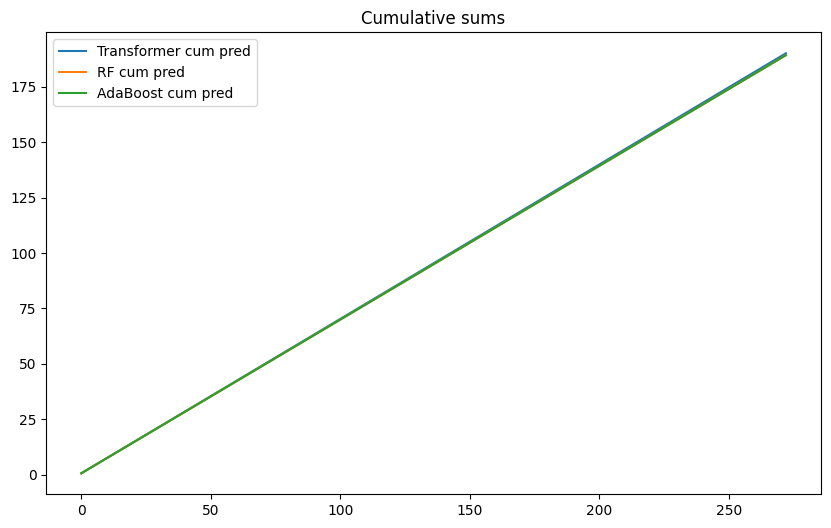

In [ ]:
# cumulative sums
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(preds), label='Transformer cum pred')
plt.plot(np.cumsum(rf_pred), label='RF cum pred')
plt.plot(np.cumsum(adb_pred), label='AdaBoost cum pred')
plt.legend()
plt.title('Cumulative sums')
plt.show()


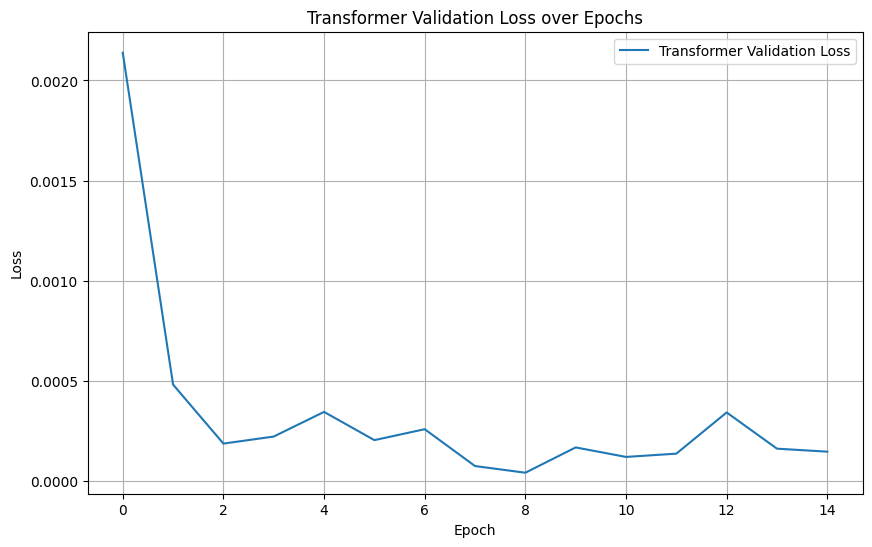

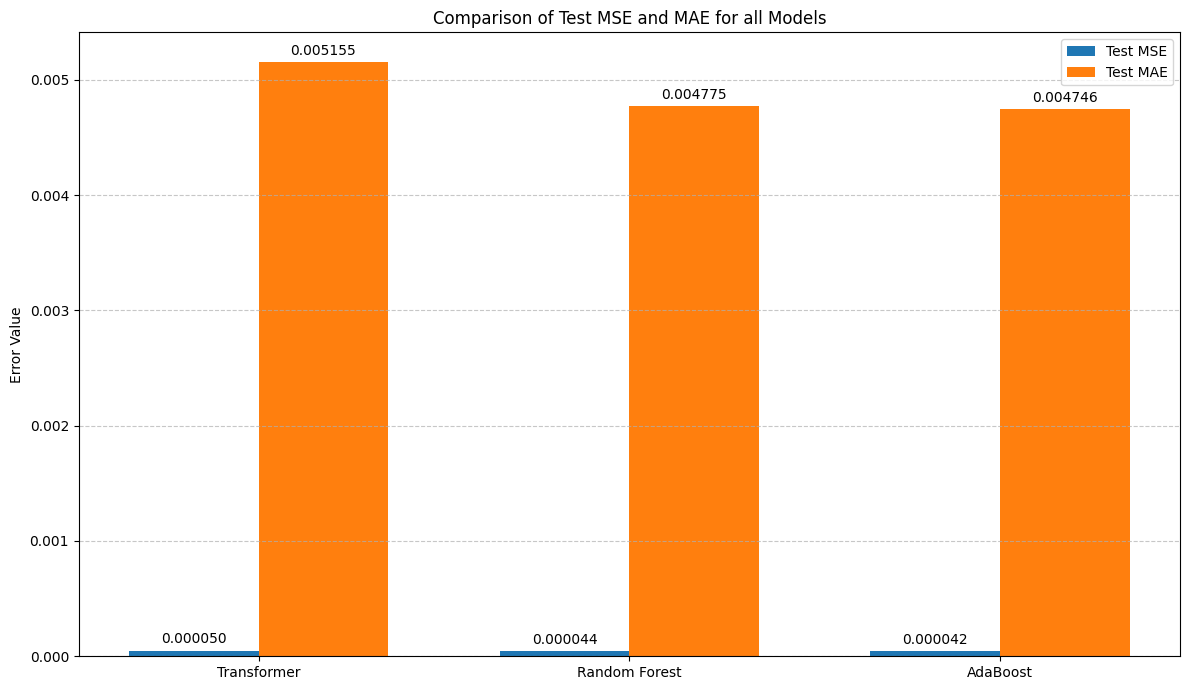

In [ ]:
# plot for validation loss comparison

# Plot Transformer Validation Loss
plt.figure(figsize=(10,6))
plt.plot(history['val_loss'], label='Transformer Validation Loss')
plt.title('Transformer Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Prepare data for test MSE/MAE comparison
transformer_mse = mean_squared_error(trues, preds)
transformer_mae = mean_absolute_error(trues, preds)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
adb_mse = mean_squared_error(y_test, adb_pred)
adb_mae = mean_absolute_error(y_test, adb_pred)

model_names = ['Transformer', 'Random Forest', 'AdaBoost']
mse_values = [transformer_mse, rf_mse, adb_mse]
mae_values = [transformer_mae, rf_mae, adb_mae]

x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, mse_values, width, label='Test MSE')
rects2 = ax.bar(x + width/2, mae_values, width, label='Test MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Error Value')
ax.set_title('Comparison of Test MSE and MAE for all Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.6f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()